<a href="https://colab.research.google.com/github/rudistiawannn/Ear-Disease-Clasification/blob/main/Fix_2_MobileNet_V2_EarDisease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Scenario 2 with MobileNet-V2

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [ ]:
import os
import random
import shutil

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D, GlobalAveragePooling2D

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./127.5,  # Normalize to range [0, 2]
    preprocessing_function=lambda x: x - 1,  # Shift to range [-1, 1]
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode="nearest"
)
validation_datagen = ImageDataGenerator(
    rescale=1./127.5,  # Normalize to range [0, 2]
    preprocessing_function=lambda x: x - 1  # Shift to range [-1, 1]
)

test_datagen = ImageDataGenerator(
    rescale=1./127.5,  # Normalize to range [0, 2]
    preprocessing_function=lambda x: x - 1  # Shift to range [-1, 1]
)

In [ ]:
# Training set and validation set
train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Ear Disease/Split Dataset/train',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)
validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/Ear Disease/Split Dataset/validation',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Ear Disease/Split Dataset/test',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
)

Found 836 images belonging to 20 classes.
Found 214 images belonging to 20 classes.
Found 233 images belonging to 20 classes.


In [ ]:
# Load the MobileNet-V2 model
pre_trained_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
for layer in pre_trained_model.layers:
    layer.trainable = False

# Define input
input_layer = Input(shape=(224, 224, 3))

# Build the model
x = pre_trained_model(input_layer)
x = GlobalAveragePooling2D()(x)
x = Dense(174, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(20, activation='softmax')(x)

# Create the model
model = Model(inputs=input_layer, outputs=output)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 174)                 │         222,894 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 174)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │           3,500 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,484,378 (9.48 MB)

 Trainable params: 226,394 (884.35 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
import tensorflow as tf

# Model Compile
OPT = tf.keras.optimizers.Adam(learning_rate=0.003103753471420176)
METRIC = tf.keras.metrics.AUC(name='auc')

model.compile(loss='categorical_crossentropy',
              metrics=[METRIC],
              optimizer=OPT)

In [ ]:
filepath = '/content/drive/MyDrive/Ear Disease/visualisasi_2_MobileNetV2.keras'

checkpoint    = ModelCheckpoint(filepath,
                                monitor = 'val_auc',
                                mode='max',
                                save_best_only=True,
                                verbose = 1)


callback_list = [checkpoint]

In [ ]:
model_history=model.fit(train_generator,
                        validation_data=validation_generator,
                        epochs = 100,

                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - auc: 0.5667 - loss: 3.4401
Epoch 1: val_auc improved from -inf to 0.74957, saving model to /content/drive/MyDrive/Ear Disease/visualisasi_2_MobileNetV2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 295s 12s/step - auc: 0.5722 - loss: 3.4116 - val_auc: 0.7496 - val_loss: 2.5956
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - auc: 0.8583 - loss: 2.1476
Epoch 2: val_auc improved from 0.74957 to 0.79825, saving model to /content/drive/MyDrive/Ear Disease/visualisasi_2_MobileNetV2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 748ms/step - auc: 0.8584 - loss: 2.1436 - val_auc: 0.7982 - val_loss: 2.3816
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - auc: 0.8980 - loss: 1.8006
Epoch 3: val_auc improved from 0.79825 to 0.81818, saving model to /content/drive/MyDrive/Ear Disease/visualisasi_2_MobileNetV2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 829ms/step - auc: 0.8985 - loss: 1.7963 - val_auc: 0.8182 - val_loss: 2.3318
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms

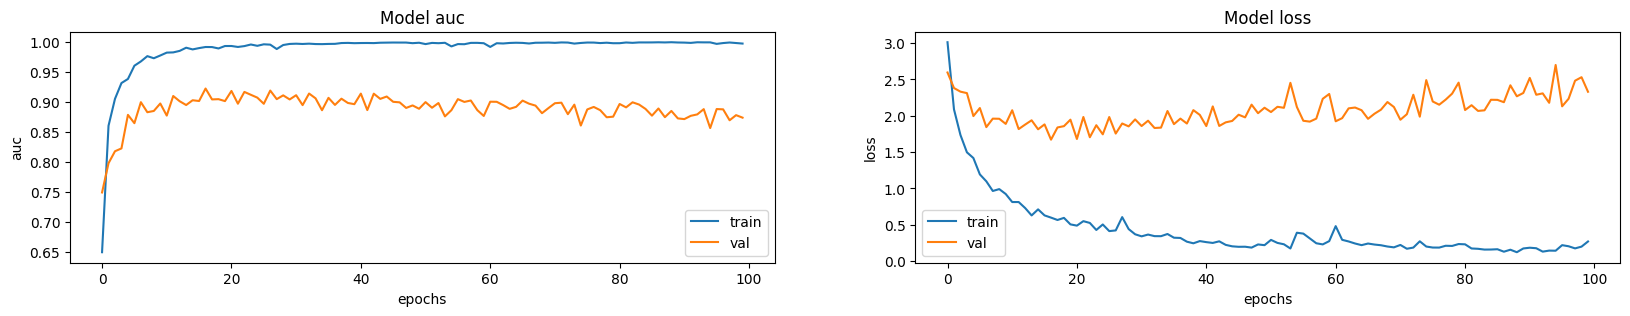

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(model_history.history[met])
    ax[i].plot(model_history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
model.evaluate(test_generator)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - auc: 0.8527 - loss: 2.6336


[2.7529056072235107, 0.8454945683479309]

In [ ]:
from tensorflow.keras.models import load_model
# Load your trained CNN model
model = load_model('/content/drive/MyDrive/Ear Disease/visualisasi_2_MobileNetV2.keras')

# Make predictions on the test set
y_pred = model.predict(test_generator)

# Extract true labels from the generator
y_true = test_generator.classes

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step


In [ ]:
from sklearn.metrics import roc_auc_score

# Compute AUC
auc = roc_auc_score(y_true, y_pred, multi_class='ovo')
print(f'AUC on the test set: {auc}')

AUC on the test set: 0.5106163449248692


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step


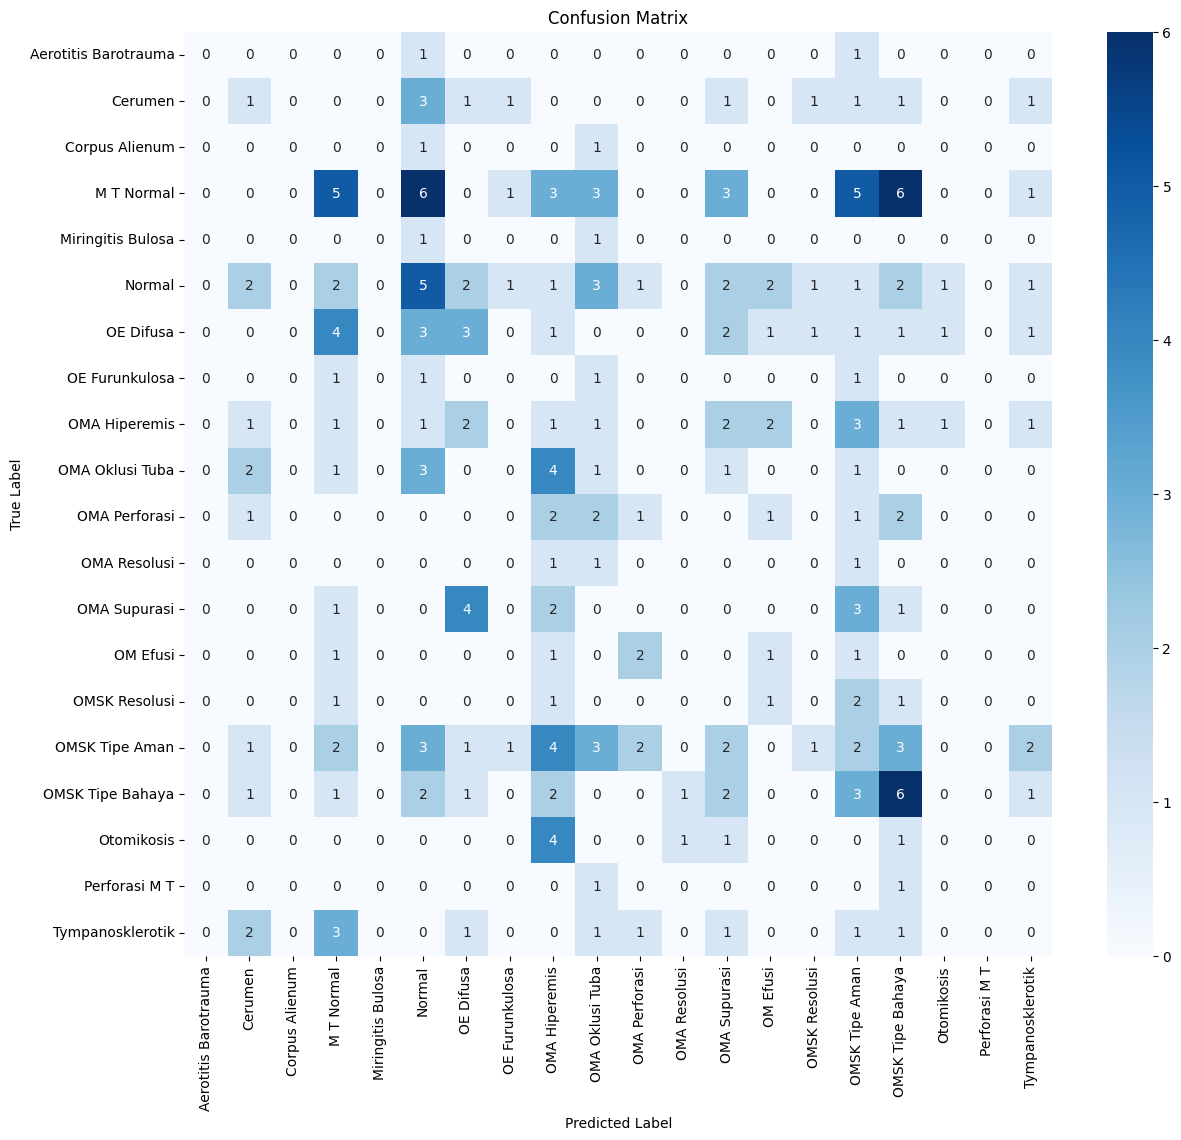

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

# Load your trained CNN model
model = load_model('/content/drive/MyDrive/Ear Disease/visualisasi_2_MobileNetV2.keras')

# Make predictions on the test set
y_pred = model.predict(test_generator)

# Extract true labels from the generator
y_true = test_generator.classes

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Define the class names
class_names = [
    'Aerotitis Barotrauma', 'Cerumen', 'Corpus Alienum', 'M T Normal', 'Miringitis Bulosa', 'Normal', 'OE Difusa', 'OE Furunkulosa',
    'OMA Hiperemis', 'OMA Oklusi Tuba', 'OMA Perforasi', 'OMA Resolusi', 'OMA Supurasi', 'OM Efusi', 'OMSK Resolusi', 'OMSK Tipe Aman',
    'OMSK Tipe Bahaya', 'Otomikosis', 'Perforasi M T', 'Tympanosklerotik'
]

# Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


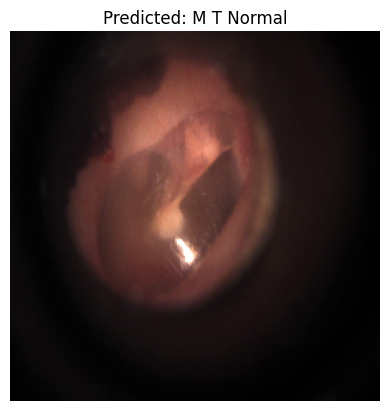

The model predicts: M T Normal


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load your trained CNN model
model = load_model('/content/drive/MyDrive/Ear Disease/visualisasi_2_MobileNetV2.keras')

# Define the class names
class_names = [
    'Aerotitis Barotrauma', 'Cerumen', 'Corpus Alienum', 'M T Normal',
    'Miringitis Bulosa', 'Normal', 'Otomikosis', 'OE Difusa',
    'OE Furunkulosa', 'OMA Hiperemis',
    'OMA Oklusi Tuba', 'OMA Perforasi',
    'OMA Resolusi', 'OMA Supurasi',
    'OM Efusi', 'OMSK Resolusi',
    'OMSK Tipe Aman', 'OMSK Tipe Bahaya',
    'Perforasi M T', 'Tympanosklerotik'
]

def load_and_preprocess_image(img_path, target_size=(224, 224)):
    # Load the image
    img = image.load_img(img_path, target_size=target_size)
    # Convert the image to array
    img_array = image.img_to_array(img)
    # Expand dimensions to match the model input
    img_array = np.expand_dims(img_array, axis=0)
    # Normalize the image
    img_array = img_array / 255.0
    return img_array

def predict_image(img_path):
    # Preprocess the image
    img_array = load_and_preprocess_image(img_path)
    # Make prediction
    predictions = model.predict(img_array)
    # Get the class with highest probability
    predicted_class = np.argmax(predictions, axis=1)
    # Get the class name
    predicted_class_name = class_names[predicted_class[0]]

    # Plot the image with prediction
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class_name}')
    plt.axis('off')
    plt.show()

    return predicted_class_name

# Test the function with an image path
img_path = '/content/drive/MyDrive/Ear Disease/Split Dataset/test/M Timpani normal/2019-08-20T19-48-12.jpg'
predicted_class_name = predict_image(img_path)
print(f'The model predicts: {predicted_class_name}')